# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [1]:
%%capture

!pip install smdebug torch torchvision tqdm --no-cache-dir

In [8]:
# Importing Libraries for Data Preparation
import sagemaker
import boto3
import os
import json
from tqdm import tqdm
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil

In [4]:
# Create temp path for data location
local_data_path = "training_data"

# Function for data preparations
def data_preparation(local_data_path):
    s3_client = boto3.client('s3')
    
    with open('file_list.json', 'r') as f:
        d=json.load(f)
        
    for k, v in d.items():
        print(f"Downloading Images with {k} objects from")
        directory=os.path.join(local_data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [5]:
data_preparation(local_data_path)

100%|██████████| 1228/1228 [01:39<00:00, 12.31it/s]


100%|██████████| 2299/2299 [03:10<00:00, 12.08it/s]


100%|██████████| 2666/2666 [03:42<00:00, 11.98it/s]


100%|██████████| 2373/2373 [03:15<00:00, 12.12it/s]


100%|██████████| 1875/1875 [02:33<00:00, 12.24it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

Downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder.
```
$ tree .
.
├── test
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
├── train
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
└── valid
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    └── 5
````

In [6]:
# Perform data exploration
main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [7]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


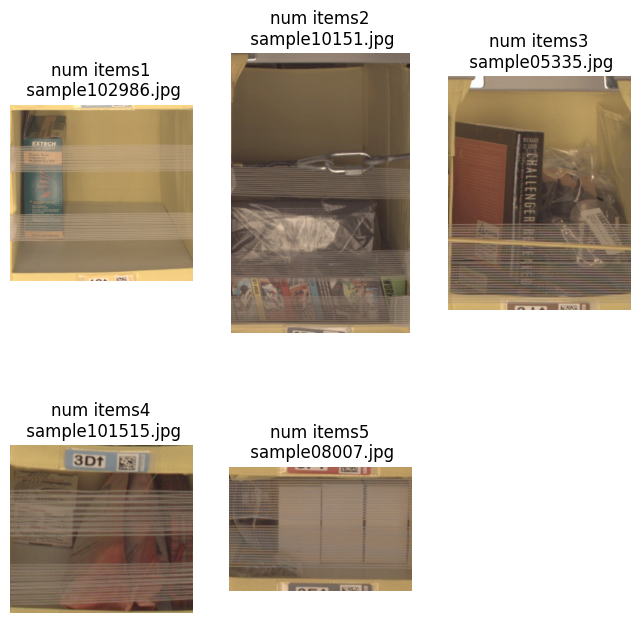

In [22]:
# Data visualzation
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2

for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample" + img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
    
plt.show()
figure.savefig('sample_dataset.png')

In [12]:
# Dataset split into Train: 60%, Test: 20%, Valid: 20%
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}

for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [13]:
import shutil

In [14]:
split_localdata_path = 'train_test_valid_split'

In [15]:
# 
try:
    os.mkdir(split_localdata_path)
    os.mkdir(os.path.join(split_localdata_path, 'valid'))
    os.mkdir(os.path.join(split_localdata_path, 'test'))
    os.mkdir(os.path.join(split_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(split_localdata_path, 'valid', key))
        os.mkdir(os.path.join(split_localdata_path, 'test', key))
        os.mkdir(os.path.join(split_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'train', key, filename))
                
print('Finished..')

Finished..


In [3]:
# General macros
session = sagemaker.Session()
print("Default Session: {}".format(session))
region = session.boto_region_name
print("AWS Region     : {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn        : {}".format(role))

Default Session: <sagemaker.session.Session object at 0x7ff03faa1dd0>
Default Bucket : sagemaker-us-east-1-933845045900
AWS Region     : us-east-1
RoleArn        : arn:aws:iam::933845045900:role/service-role/AmazonSageMaker-ExecutionRole-20230130T210045


In [16]:
#arn:aws:s3:::object-count-tracking-using-aws-sagemaker
#s3://object-count-tracking-using-aws-sagemaker/
bucket_path = "s3://object-count-tracking-using-aws-sagemaker/"
dataset_path = os.path.join(bucket_path, split_localdata_path)
print(f"S3 bucket path    : {bucket_path}")
print(f"Dataset path in S3: {dataset_path}")

S3 bucket path    : s3://object-count-tracking-using-aws-sagemaker/
Dataset path in S3: s3://object-count-tracking-using-aws-sagemaker/train_test_valid_split


In [17]:
os.environ["DATASET_PATH"] = dataset_path
os.environ["DATASET_ORIGIN_PATH"] = split_localdata_path

In [19]:
# Upload the data to AWS S3 using sync
# https://awscli.amazonaws.com/v2/documentation/api/latest/reference/s3/sync.html
!aws s3 sync ${DATASET_ORIGIN_PATH} ${DATASET_PATH} --only-show-errors

## Hyperparameter Tuning

This part involves using external python scripts:

    1. Hyperparameters tuning through `hpo.py`
    2. Tain with optional concurrency `train.py`

In [20]:
# Importing Libraries needed for Model Training
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig
from sagemaker.debugger import ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

In [23]:
# Hyperparameter search space
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [25]:
# Training estimator
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='Amazon buckets HP search',
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=10,
    objective_type=objective_type
)

In [26]:
# Defined macros
os.environ["SM_CHANNEL_TRAINING"] = dataset_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path + "/model/" # where model will be stored

In [27]:
# Fit  estimator
tuner.fit({"training": dataset_path}, wait = True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [28]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-230209-0721


In [30]:
exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=latest_hyperparameter_tuning_job_name)

jobs = exp.dataframe()

In [31]:
jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,"""128""",0.096048,pytorch-training-230209-0721-007-2924c748,Completed,45.246983,2023-02-09 07:22:55+00:00,2023-02-09 07:30:43+00:00,468.0
1,"""256""",0.013362,pytorch-training-230209-0721-009-e642f64e,Completed,13.012752,2023-02-09 07:22:56+00:00,2023-02-09 07:31:04+00:00,488.0
2,"""256""",0.010037,pytorch-training-230209-0721-008-74918001,Completed,6.544734,2023-02-09 07:22:57+00:00,2023-02-09 07:31:01+00:00,484.0
7,"""64""",0.010193,pytorch-training-230209-0721-003-36bb93f6,Completed,1.797816,2023-02-09 07:22:46+00:00,2023-02-09 07:30:15+00:00,449.0
4,"""128""",0.001987,pytorch-training-230209-0721-006-d72c50c4,Completed,1.697828,2023-02-09 07:22:54+00:00,2023-02-09 07:30:28+00:00,454.0
5,"""64""",0.002488,pytorch-training-230209-0721-005-cdb0e388,Completed,1.697160,2023-02-09 07:22:50+00:00,2023-02-09 07:30:19+00:00,449.0
9,"""32""",0.019110,pytorch-training-230209-0721-001-03113e74,Completed,1.683433,2023-02-09 07:22:52+00:00,2023-02-09 07:30:05+00:00,433.0
0,"""512""",0.001901,pytorch-training-230209-0721-010-b8ea65f5,Completed,1.659610,2023-02-09 07:23:27+00:00,2023-02-09 07:32:45+00:00,558.0
6,"""64""",0.002313,pytorch-training-230209-0721-004-dae311c5,Completed,1.635567,2023-02-09 07:22:51+00:00,2023-02-09 07:30:56+00:00,485.0
8,"""32""",0.005339,pytorch-training-230209-0721-002-789d5561,Completed,1.588916,2023-02-09 07:22:47+00:00,2023-02-09 07:30:00+00:00,433.0


In [32]:
best_estimator=tuner.best_estimator()


2023-02-09 07:30:02 Starting - Preparing the instances for training
2023-02-09 07:30:02 Downloading - Downloading input data
2023-02-09 07:30:02 Training - Training image download completed. Training in progress.
2023-02-09 07:30:02 Uploading - Uploading generated training model
2023-02-09 07:30:02 Completed - Resource retained for reuse


In [33]:
# Best hyperparameters
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.005339291333527525',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Amazon buckets HP search-2023-02-09-07-21-30-880"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-933845045900/Amazon buckets HP search-2023-02-09-07-21-30-880/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [34]:
# Update values
hyperparameter_values = {
    "learning_rate": 0.005339291333527525,
    "batch_size": 32,
}
hyperparameter_values

{'learning_rate': 0.005339291333527525, 'batch_size': 32}

In [35]:
# Set debug rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [36]:
# Set profile rules & hooks
debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [37]:
# Create estimator
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [38]:
# Dataset location
os.environ["SM_CHANNEL_TRAINING"] = dataset_path
# model location
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" 

In [39]:
# Fit an estimator
estimator.fit({"training": dataset_path}, wait= True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-09-08-12-58-820


2023-02-09 08:12:59 Starting - Starting the training job...
2023-02-09 08:13:23 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-09 08:14:23 Downloading - Downloading input data...
2023-02-09 08:14:51 Training - Downloading the training image...
2023-02-09 08:15:23 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-09 08:15:27,709 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-09 08:15:27,712 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-09 08:15:27,720 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-09 08:15:27,722 sagemaker_pytorch_container.training INFO  

In [ ]:
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

In [ ]:
# Print the latest training job’s rule summary in real time
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f'job_name: {job_name}')
print(f'client: {client}')

In [ ]:
# TODO: Plot a debugging output.

In [ ]:
# Display the profiler output
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances